# Multilingual Universal Sentence Encoder

Multilingual Unversal Sentence Encoder เป็น model ในการทำ sentence embedding โดยที่ embeding ของ 16 ภาษานั้นจะอยู่ใน Vector Space เดียวกัน นั้นหมายความว่าเราสามารถหาความเหมือนของประโยคข้ามภาษากันได้  
<br>

ซึ่งใน colab นี้เราจะมาลองดูกันว่าทำยังไงในการตรวจสอบคุณภาพข้อมูลจาก [opensubtitle](http://opus.nlpl.eu/OpenSubtitles-v2018.php)

<br>
จัดทำโดย สถาบันวิจัยปัญญาประดิษฐ์ประเทศไทย (AIResearch)
<br>
Facebook & Medium: AIResearch.in.th

## Installation & Package 

ในการหยิบ model USE ของ google มาใช้เราจำเป็นต้องมี
 - tensorflow 2.x 
 - tensorflow_text 
 - tensorflow_hub

In [ ]:
%tensorflow_version 2.x

In [ ]:
!pip install tensorflow_text

     |████████████████████████████████| 8.3MB 5.7MB/s 
     |████████████████████████████████| 421.8MB 45kB/s 
     |████████████████████████████████| 450kB 41.8MB/s 
     |████████████████████████████████| 3.9MB 35.5MB/s 
  Created wheel for gast: filename=gast-0.2.2-cp36-none-any.whl size=7540 sha256=3365f089f0d53187db6733fd95b616a388dc487261c70b6c58fe0f105844a04c
  Stored in directory: /root/.cache/pip/wheels/5c/2e/7e/a1d4d4fcebe6c381f378ce7743a3ced3699feb89bcfbdadadd
Successfully built gast
ERROR: tensorflow-probability 0.10.0rc0 has requirement gast>=0.3.2, but you'll have gast 0.2.2 which is incompatible.
  Found existing installation: tensorflow-estimator 2.2.0
    Uninstalling tensorflow-estimator-2.2.0:
      Successfully uninstalled tensorflow-estimator-2.2.0
  Found existing installation: gast 0.3.3
    Uninstalling gast-0.3.3:
      Successfully uninstalled gast-0.3.3
  Found existing installation: tensorboard 2.2.1
    Uninstalling tensorboard-2.2.1:
      Successfully uni

In [ ]:
import tensorflow_hub as hub
import tensorflow_text
import tensorflow as tf

import numpy as np
import json
import pandas as pd
import itertools

## Dataset

ชุด dataset นี้เป็นข้อมูลในการทำ subtitle มีจำนวนทั้งหมดประมาณ 3.2 ล้านคู่ประโยค

In [ ]:
#download open subtitle EN-TH dataset
!wget http://opus.nlpl.eu/download.php?f=OpenSubtitles/v2018/moses/en-th.txt.zip

--2020-05-11 07:25:46--  http://opus.nlpl.eu/download.php?f=OpenSubtitles/v2018/moses/en-th.txt.zip
Resolving opus.nlpl.eu (opus.nlpl.eu)... 193.166.25.9
Connecting to opus.nlpl.eu (opus.nlpl.eu)|193.166.25.9|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://object.pouta.csc.fi/OPUS-OpenSubtitles/v2018/moses/en-th.txt.zip [following]
--2020-05-11 07:25:46--  https://object.pouta.csc.fi/OPUS-OpenSubtitles/v2018/moses/en-th.txt.zip
Resolving object.pouta.csc.fi (object.pouta.csc.fi)... 86.50.254.18, 86.50.254.19
Connecting to object.pouta.csc.fi (object.pouta.csc.fi)|86.50.254.18|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 119520928 (114M) [application/zip]
Saving to: ‘download.php?f=OpenSubtitles%2Fv2018%2Fmoses%2Fen-th.txt.zip’

download.php?f=Open 100%[===================>] 113.98M  53.4MB/s    in 2.1s    

2020-05-11 07:25:49 (53.4 MB/s) - ‘download.php?f=OpenSubtitles%2Fv2018%2Fmoses%2Fen-th.txt.zip’ saved [119520928/

In [ ]:
!unzip download.php?f=OpenSubtitles%2Fv2018%2Fmoses%2Fen-th.txt.zip -d data

Archive:  download.php?f=OpenSubtitles%2Fv2018%2Fmoses%2Fen-th.txt.zip
  inflating: data/OpenSubtitles.en-th.en  
  inflating: data/OpenSubtitles.en-th.th  
  inflating: data/OpenSubtitles.en-th.ids  
  inflating: data/README             


In [ ]:
# Create function to read both en and th
def read_text_file(path):
  output = []

  with open(path, 'r') as read_file:
    for line in read_file.readlines():
      output.append(line)
   
  return output

In [ ]:
en_data = read_text_file('data/OpenSubtitles.en-th.en')
th_data = read_text_file('data/OpenSubtitles.en-th.th')

In [ ]:
df = pd.DataFrame({'en_data': en_data, 
                   'th_data': th_data})

In [ ]:
df.shape

(3281533, 2)

In [ ]:
#ดู head ก็ดูดีอยู่
df.head()

,en_data,th_data
0,"Slave in the Magic Mirror, come from the farth...","ทาสในกระจกวิเศษ, มาจากพื้นที่ที่ไกลที่สุด\n"
1,"Through wind and darkness, I summon thee.\n",ผ่านลมและความมืดฉันเรียกเจ้า\n
2,Speak!\n,พูด!\n
3,Let me see thy face.\n,ให้ฉันเห็นพระพักตร์ของ พระองค์\n
4,"What wouldst thou know, my Queen?\n",สิ่งที่เจ้าจะรู้ว่าสมเด็จพระราชินี ของฉันได้อย...


In [ ]:
#แต่ก็มีบางอันที่แปลไม่ถูกเหมือนกัน
df.iloc[645316]

en_data                                      Sorry, boys.\n
th_data    ออกไปจากที่นี่ได้ ฉันจะเปลี่ยนแปลงตัว โอเคมั้ย\n
Name: 645316, dtype: object

## Multilingual Unversal Sentence Encoder from Tensorflow hub

In [ ]:
#Create USE embedding by using tensorflow hub
embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder-multilingual/3")

In [ ]:
#Create mockup sentence
sentences = ['ฉันชอบหมามากๆ']

In [ ]:
#Get sentence embedding
embed(sentences)

<tf.Tensor: shape=(1, 512), dtype=float32, numpy=
array([[ 0.03348423, -0.06594724,  0.03950755,  0.04621329, -0.10738036,
         0.01468914, -0.02351864,  0.0491148 , -0.08298343,  0.01641721,
        -0.02722485,  0.01400877,  0.09527715,  0.06409989,  0.01069192,
         0.04308213, -0.02290481, -0.00523085,  0.07797866,  0.05206088,
        -0.01314825,  0.00568864, -0.02676987,  0.0304546 , -0.07763009,
        -0.05057951,  0.04949673, -0.0261358 ,  0.01342152, -0.04488368,
        -0.04447207, -0.01044451, -0.04691579, -0.07239084,  0.02885035,
        -0.00017215, -0.01861167, -0.03902013, -0.01487683,  0.00985493,
         0.02210216,  0.00267068, -0.0216059 ,  0.07730269, -0.05926208,
        -0.08935834, -0.09016439,  0.01313246, -0.00555023, -0.01097908,
         0.05580696,  0.0093157 ,  0.01226588, -0.0465791 ,  0.0735788 ,
         0.00390066, -0.08514211, -0.00407269,  0.07633574, -0.02093282,
         0.02272809, -0.00105881, -0.00021839,  0.05675113,  0.07545897,
 

## Find distance

In [ ]:
def get_similar_score(lang1: list, lang2:list , batch_size:int):
  '''
  get_similar_score is a function to get similarity score of sentence pair


  Input: 
   lang1: list of sentence of lang1 
   lang2: list of sentence of lang2 
   batch_size: batch_size

   ** As sometime data is too big, too do on one go
      the we need to do it as a batch
  
  outout: 
   scores: list of score
  '''

  scores =[]

  if len(lang1)%batch_size != 0:
    num_of_batch = int(len(lang1)/batch_size)+1
  else:
    num_of_batch = int(len(lang1)/batch_size)
  
  print(num_of_batch)

  for i in range(num_of_batch):
    start = i*batch_size
    end = start+batch_size
    if i <= num_of_batch:

      lang1_temp = lang1[start:end]
      lang2_temp = lang2[start:end]
      
      lang1_embedding = embed(lang1_temp)
      lang2_embedding = embed(lang2_temp)
      distance_matrix = tf.matmul(lang1_embedding, lang2_embedding, transpose_b=True).numpy()

      for j in range(len(distance_matrix)):
        scores.append(distance_matrix[j][j])

  return scores

In [ ]:
scores = get_similar_score(en_data, th_data, 10000)

329


In [ ]:
#Create dataframe that has en, th, score as a columns
df = pd.DataFrame({'en':en_data, 'th': th_data, 'score':scores})

In [ ]:
df.head()

,en,th,score
0,"Slave in the Magic Mirror, come from the farth...","ทาสในกระจกวิเศษ, มาจากพื้นที่ที่ไกลที่สุด\n",0.726472
1,"Through wind and darkness, I summon thee.\n",ผ่านลมและความมืดฉันเรียกเจ้า\n,0.802946
2,Speak!\n,พูด!\n,0.742168
3,Let me see thy face.\n,ให้ฉันเห็นพระพักตร์ของ พระองค์\n,0.536011
4,"What wouldst thou know, my Queen?\n",สิ่งที่เจ้าจะรู้ว่าสมเด็จพระราชินี ของฉันได้อย...,0.807820


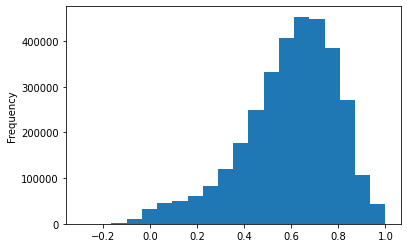

In [ ]:
df['score'].plot(kind='hist', bins=20)

In [ ]:
#low score sentence trend to get bad translation
df[(df['score'])<0.3].sample(5)

,en,th,score
473414,Me scratching to get in.\n,ฉันพยายามเข้าถึงคุณด้วยความยากลำบาก\n,0.267541
973238,Why are you...\n,ทำไม่เธอ\n,0.198270
3135474,So we expand our team.\n,แปลว่าต้องหาคนเพิ่ม\n,0.130799
1677727,"Yes, Oppa.\n",ค่ะ พี่ชาย\n,0.225503
2135285,Angelique...\n,ขอโทษนะแอนเจลิค แต่\n,0.246243


In [ ]:
#high score sentence trend to get good translation
df[(df['score'])>0.7].sample(5)

,en,th,score
810183,There is no other country in the world!\n,ไม่มีประเทศไหนในโลก\n,0.763642
1374847,I am comfortable if you choose to believe that.\n,ฉันจะรู้สึกดีถ้าคุณเลือกที่จะเชื่ออย่างนั้น\n,0.712632
2808010,It was an experience.\n,มันเป็นประสบการณ์\n,0.917878
520569,I am going to kill them. I will die?\n,ฉันกำลังจะไปฆ่าเค้า ฉันกำลังจะตาย?\n,0.852705
1423503,"I explicitly say I want no air freshener, and ...",ฉันขอพูดอย่างชัดเจน ฉันไม่อยากสูดมลพิษทางอากาศ...,0.712072
